# Programming Assessment

Time given: 1 day

Model (predictive) the duration of outage as a function of a set of input variables – such as climate information, <br> outage information, electricity consumption, economic characteristics, and land use characteristics.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
sns.set_palette("muted")

pd.set_option('display.max_columns', None)

## Read Data

In [2]:
df = pd.read_excel("Major Outage Data - Cabatingan, Arthur.xlsx")
print(df.shape)
df.head(3)

(1534, 54)


,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,2011-07-03,20:00:00,severe weather,NaN,NaN,3060.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736,276286,10673,2595696,88.944776,10.644005,0.411181,51268,47586,1.077376,1.6,4802,274182,1.751391,2.2,5348119,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,2014-05-11,18:39:00,intentional attack,vandalism,NaN,1.0,12.12,9.71,6.49,9.28,1586986.0,1807756.0,1887927.0,5284231.0,30.032487,34.210389,35.727564,2345860,284978,9898,2640737,88.833534,10.791609,0.374820,53499,49091,1.089792,1.9,5226,291955,1.790002,2.2,5457125,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,2010-10-28,22:00:00,severe weather,heavy wind,NaN,3000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291,276463,10150,2586905,88.920583,10.687018,0.392361,50447,47287,1.066826,2.7,4571,267895,1.706266,2.1,5310903,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


## Initial Preprocessing

In [3]:
# rename fields for consistent formatting
df.columns = [x.replace('.', '_') 
    if 'U.S.' not in x 
    else x.replace('.','') for x in df.columns]
# df.apply(lambda x: x.astype(str).str.contains('NA').any(), axis=1).sum() #already read as nan
df.set_index('OBS', inplace=True)
df = df[(df.CAUSE_CATEGORY == 'severe weather') & (df.OUTAGE_DURATION > 0)]
df.shape

(741, 53)

In [4]:
# sanity check for OUTAGE_DURATION
z = lambda x,y: pd.to_datetime(df[x].dt.strftime('%Y-%m-%d')\
    + df[y].astype(str), 
    format = '%Y-%m-%d%H:%M:%S')
x = (z('OUTAGE_RESTORATION_DATE', 'OUTAGE_RESTORATION_TIME')\
    - z('OUTAGE_START_DATE', 'OUTAGE_START_TIME'))\
    / pd.Timedelta(1, 'T') 
y = x == df.OUTAGE_DURATION

# 24/741 (3.2%) observations are probably miscalculated
# example:OBS 205, 39hrs 20mins = 2360 vs 2420 on record
print(y.value_counts(), y.value_counts(normalize=True))

# update values of target variable
df['OUTAGE_DURATION'] = x

True     717
False     24
dtype: int64 True     0.967611
False    0.032389
dtype: float64


In [5]:
# check percentage of null values
# candidates for dropping entire column vs dropping rows
''' 
rule of thumb:
    < 5% - drop rows/ fill
    25-30% - fill if aplicable
    > 30% - drop column
'''
x = df.isnull().sum()*100 / len(df)
x[x>0]

CLIMATE_REGION            0.539811
CAUSE_CATEGORY_DETAIL    23.616734
HURRICANE_NAMES          90.418354
RES_PRICE                 0.674764
COM_PRICE                 0.674764
IND_PRICE                 0.674764
TOTAL_PRICE               0.674764
RES_SALES                 0.674764
COM_SALES                 0.674764
IND_SALES                 0.674764
TOTAL_SALES               0.674764
RES_PERCEN                0.674764
COM_PERCEN                0.674764
IND_PERCEN                0.674764
POPDEN_UC                 1.214575
POPDEN_RURAL              1.214575
dtype: float64

In [6]:
# 18 records dropped
df.dropna(subset=x[(x>0) & (x<5)].index, inplace=True)
df.shape

(723, 53)

In [7]:
# initial dropping of fields that are not likely helpful:
# HURRICANE_NAMES - has nothing to do with outage duration and ~90% of events are not hurricanes
# CAUSE_CATEGORY - since we are only considering 'severe weather'
# POSTAL_CODE - use US_STATE instead
df.drop(['HURRICANE_NAMES', 'CAUSE_CATEGORY', 'POSTAL_CODE'], 
    inplace=True, axis=1)

(711, 50)

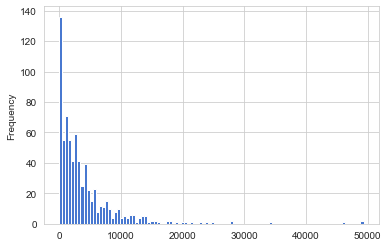

In [8]:
# check distribution of outage duration 
df.OUTAGE_DURATION.plot.hist(bins=100)

# remove 'outliers' by capping values: <=20,000 w/c is ~2weeks
# 12 records dropped
df = df[df.OUTAGE_DURATION <= 20000]
df.shape

## Exploratory Data Analysis

### General and Regional Climate Informatimon

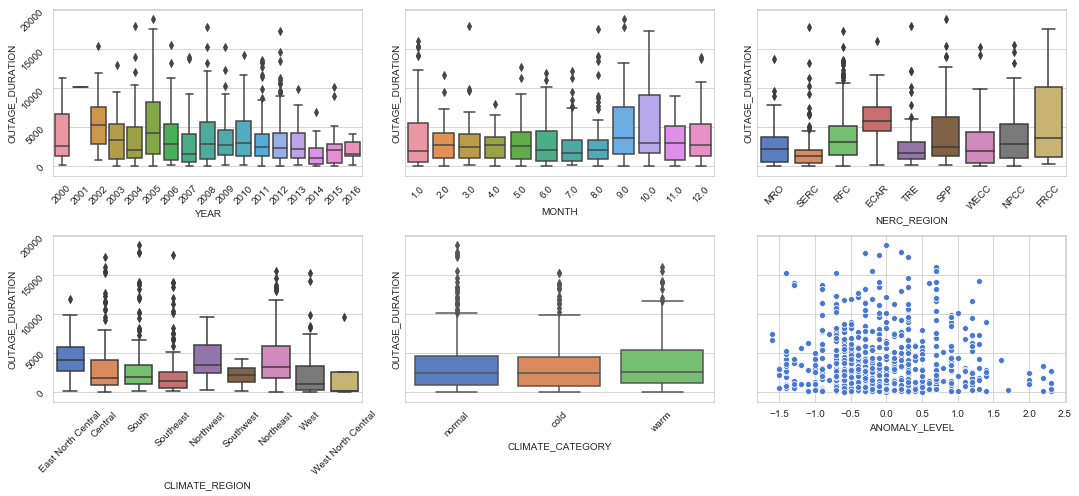

In [9]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(15,7))
cols = ['YEAR', 'MONTH', 'NERC_REGION', 'CLIMATE_REGION', 'CLIMATE_CATEGORY']
for i,c in enumerate(cols):
    ax = axs[int(i>2), i%3]
    sns.boxplot(x=c, y='OUTAGE_DURATION', data=df, ax=ax)
    ax.tick_params(labelrotation=45)
sns.scatterplot(x="ANOMALY_LEVEL", y="OUTAGE_DURATION", data=df, ax=axs[1,2])
plt.tight_layout()

- As the years progress, it seems that `OUTAGE_DURATION` drops. Probably due to better technology/infrastructure/operations
- `OUTAGE_DURATION` seems to vary depending on the `MONTH`, `NERC_REGION`, US `CLIMATE` regions
- Median `OUTAGE_DURATION` looks uniform across El Niño/La Niña `CLIMATE_CATEGORY`. <br>Drop column?, `ANOMALY_LEVEL` should capture more information plus its computation seems robust against effects of minor observation errors (?) that necessitates data binning
- Looking at `ANOMALY_LEVEL`, it seems that `OUTAGE_DURATION` are longer during normal conditions and shorter warm condition

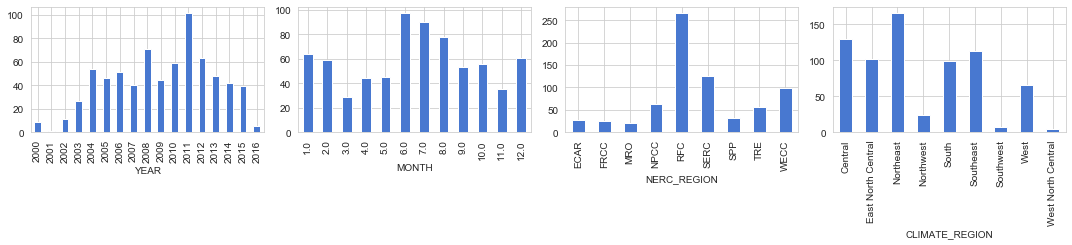

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15,3.5))
for i,c in enumerate(['YEAR', 'MONTH', 'NERC_REGION', 'CLIMATE_REGION']):
    df.groupby(c).size().plot.bar(ax=axs[i])
plt.tight_layout()

It seems that there are more power outages during summer

### Outage Events Information


In [11]:
# drop event end information 
df.drop(['OUTAGE_RESTORATION_DATE','OUTAGE_RESTORATION_TIME'], 
    inplace=True, axis=1)

In [12]:
# Create OUTAGE_TIME_OF_DAY and OUTAGE_DAY_OF_WEEK faetures
# TODO: try binning e.g. early morning, late afternoon
df['OUTAGE_TIME_OF_DAY'] = df.OUTAGE_START_TIME.apply(lambda x : x.hour) 
df['OUTAGE_DAY_OF_WEEK'] = df.OUTAGE_START_DATE.dt.day_name()

df.drop(['OUTAGE_START_DATE', 'OUTAGE_START_TIME'], 
    inplace=True, axis=1)

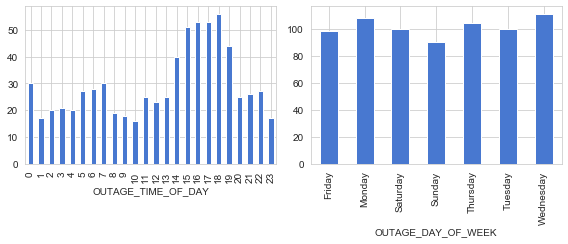

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8,3.5))
for i,c in enumerate(['OUTAGE_TIME_OF_DAY', 'OUTAGE_DAY_OF_WEEK']):
    df.groupby(c).size().plot.bar(ax=axs[i])
plt.tight_layout()

It seems that more outages occur in the afternoon (assuming time is local not utc)

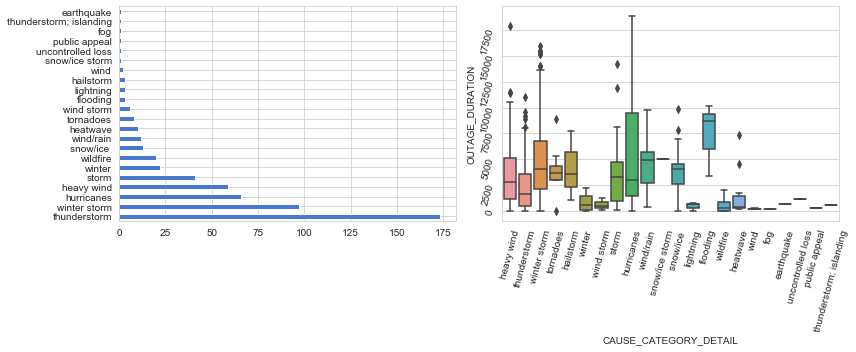

In [14]:
fig, axs = plt.subplots(1, 2,  figsize=(12, 5))
df['CAUSE_CATEGORY_DETAIL'].value_counts().plot.barh(ax=axs[0])
sns.boxplot(x='CAUSE_CATEGORY_DETAIL', y='OUTAGE_DURATION', data=df, ax=axs[1])
axs[1].tick_params(labelrotation=75)
plt.tight_layout()

Thunderstorms seems to be the #1 cause of severe-weather-related power outage in the US <br> although longest outages seems to occur during flooding (3 data points only, not reliable)

### Regional Electricity Consumption Information

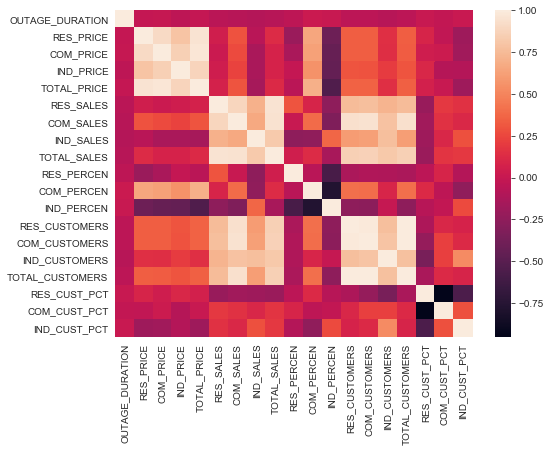

In [15]:
# visual check for multicollinearity
cols = ['RES_PRICE', 'COM_PRICE',
    'IND_PRICE', 'TOTAL_PRICE', 'RES_SALES', 'COM_SALES', 'IND_SALES',
    'TOTAL_SALES', 'RES_PERCEN', 'COM_PERCEN', 'IND_PERCEN',
    'RES_CUSTOMERS', 'COM_CUSTOMERS', 'IND_CUSTOMERS', 'TOTAL_CUSTOMERS',
    'RES_CUST_PCT', 'COM_CUST_PCT', 'IND_CUST_PCT']

plt.figure(figsize=(8,6))
ax = sns.heatmap(df[['OUTAGE_DURATION']+cols].corr())

As expected (linear relationship), we can see groups of features (price, sales, customers) that are highly correlated. <br>
Sales/consumption is also higly correlated with customers served which is also expected. <br>
With this, we only retain `TOTAL_PRICE` and `TOTAL_SALES` <br>

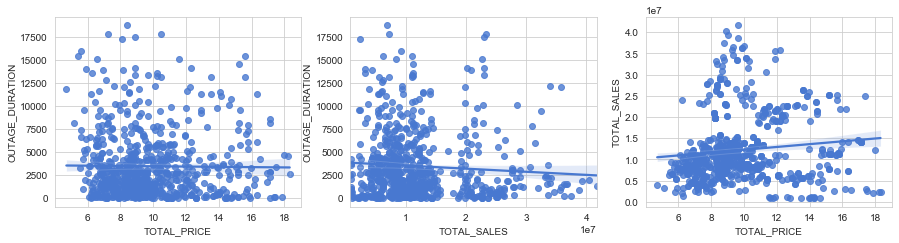

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15,3.5))
for i,c in enumerate(['TOTAL_PRICE', 'TOTAL_SALES']):
    sns.regplot(x=c, y='OUTAGE_DURATION', data=df, ax=axs[i])
sns.regplot(x='TOTAL_PRICE', y='TOTAL_SALES', data=df, ax=axs[2])

Looking at subplot3, It seems that average monthly electricity price (`TOTAL_SALES`) gets higher <br>
as total elctricity consumption (`TOTAL_PRICE`)  increases. Probably supply doesn't keep up with <br> demand but then it seems that there are less outages with lower duration when sales is higher (subplot 2)

In [17]:
df.drop([x for x in cols if x not in ['TOTAL_PRICE', 'TOTAL_SALES']], 
    inplace=True, axis=1)

### Regional Economic Characteristics

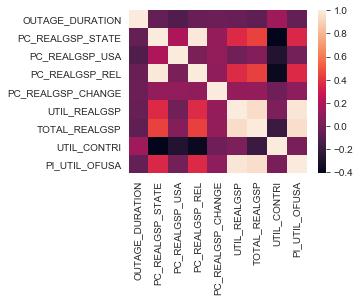

In [18]:
cols = ['PC_REALGSP_STATE', 'PC_REALGSP_USA', 
       'PC_REALGSP_REL', 'PC_REALGSP_CHANGE', 'UTIL_REALGSP', 
       'TOTAL_REALGSP', 'UTIL_CONTRI', 'PI_UTIL_OFUSA']

plt.figure(figsize=(4,3))
ax = sns.heatmap(df[['OUTAGE_DURATION']+cols].corr())

Retain columns : 

`PC_REALGSP_STATE` - highly correlated with `PC_REALGSP_REL`, `PC_REALGSP_USA` most likely just similar across states (?) <br>
`PC_REALGSP_CHANGE` <br>
`UTIL_REALGSP` - highly correlated with `TOTAL_REALGSP`<br>
`UTIL_CONTRI`<br>

In [19]:
df.drop(['PC_REALGSP_USA', 'PC_REALGSP_REL', 'TOTAL_REALGSP', 'PI_UTIL_OFUSA'], 
    inplace=True, axis=1)

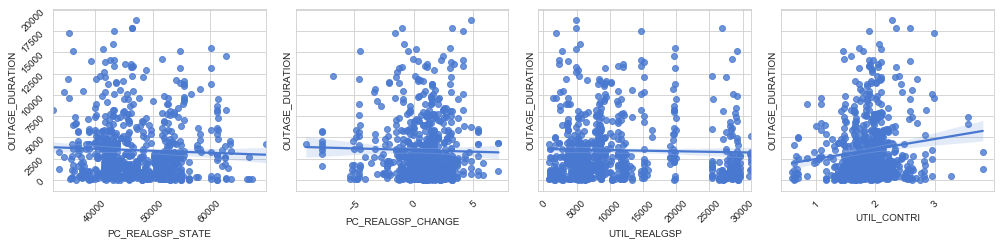

In [20]:
cols = ['PC_REALGSP_STATE', 'PC_REALGSP_CHANGE', 'UTIL_REALGSP', 'UTIL_CONTRI']

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,3.5))
for i,c in enumerate(cols):
    sns.regplot(x=c, y='OUTAGE_DURATION', data=df, ax=axs[i])
    axs[i].tick_params(labelrotation=45)
plt.tight_layout()

### Regional Land-Use Characteristics

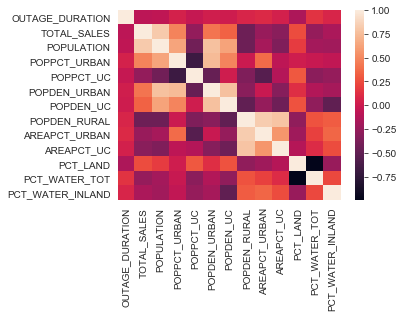

In [21]:
cols = ['POPULATION','POPPCT_URBAN', 'POPPCT_UC', 'POPDEN_URBAN', 
    'POPDEN_UC', 'POPDEN_RURAL', 'AREAPCT_URBAN', 'AREAPCT_UC', 
    'PCT_LAND', 'PCT_WATER_TOT', 'PCT_WATER_INLAND']

plt.figure(figsize=(5,3.5))
ax = sns.heatmap(df[['OUTAGE_DURATION', 'TOTAL_SALES']+cols].corr())

`TOTAL_SALES, POPPCT_URBAN, PCT_LAND` is highly correlated with `POPULATION, POPPCT_UC, PCT_WATER_TOT` respectively. <br>
Choose former.


In [22]:
df.drop(['POPULATION', 'POPPCT_UC', 'PCT_WATER_TOT'], 
    inplace=True, axis=1)

## More Preprocessing

##### Drop other highly correlated columns (|r|>0.7) that are not captured on manual inspection

In [23]:
corr_df = df.corr().abs()
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool))
to_drop = [x for x in upper_tri.columns if any(upper_tri[x] > 0.7)]
print(to_drop)
df.drop(to_drop, inplace=True, axis=1)
print(len(df.columns))

['UTIL_REALGSP', 'POPDEN_URBAN', 'POPDEN_UC', 'AREAPCT_URBAN', 'AREAPCT_UC']
20


From 53 columns, we are down to 18 + 2.

##### Drop/simplify some categorical some variables to simplify model as this will explode # of features when encoded

In [24]:
# df.drop(['YEAR', 'MONTH', 'US_STATE',], inplace=True, axis=1)
# df.CAUSE_CATEGORY_DETAIL.fillna('others', inplace=True)
#
# # mapped with no domain knowledge
# # combine similar categories
# cat_map = {
#     'thunderstorm':['thunderstorm', 'thunderstorm; islanding'],
#     'winter':['winter storm', 'winter'], 
#     'hurricanes':['hurricanes'], 
#     'tornadoes':['tornadoes'],
#     'wind':['heavy wind', 'wind/rain', 'wind storm', 'wind'],  
#     'storm':['storm'],
#     'wildfire':['wildfire'], 
#     'heatwave':['heatwave'],
#     'ice':['snow/ice ', 'snow/ice storm', 'hailstorm'], 
#     'others':['flooding','lightning','earthquake','fog','public appeal','uncontrolled loss']
#     }
# c = 'CAUSE_CATEGORY_DETAIL'
# for key, val in cat_map.items():
#     df.loc[df[c].isin(val), c] = key
# df.CAUSE_CATEGORY_DETAIL.unique()

## Choose Baseline Model

In the interest of time, we'll only compare Multiple Linear Regression and XGBoost <br>
and onl use RSME as evaluation metric

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [26]:
print(df.shape)
df.head(3)

(711, 20)


,YEAR,MONTH,US_STATE,NERC_REGION,CLIMATE_REGION,ANOMALY_LEVEL,CLIMATE_CATEGORY,CAUSE_CATEGORY_DETAIL,OUTAGE_DURATION,TOTAL_PRICE,TOTAL_SALES,PC_REALGSP_STATE,PC_REALGSP_CHANGE,UTIL_CONTRI,POPPCT_URBAN,POPDEN_RURAL,PCT_LAND,PCT_WATER_INLAND,OUTAGE_TIME_OF_DAY,OUTAGE_DAY_OF_WEEK
OBS,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MRO,East North Central,-0.3,normal,NaN,3060.0,9.28,6562520.0,51268,1.6,1.751391,73.27,18.2,91.592666,5.478743,17,Friday
3,2010,10.0,Minnesota,MRO,East North Central,-1.5,cold,heavy wind,3000.0,8.15,5222116.0,50447,2.7,1.706266,73.27,18.2,91.592666,5.478743,20,Tuesday
4,2012,6.0,Minnesota,MRO,East North Central,-0.1,normal,thunderstorm,2550.0,9.19,5787064.0,51598,0.6,1.932089,73.27,18.2,91.592666,5.478743,4,Tuesday


In [27]:
# separate dependent and independent feautres
target_col = 'OUTAGE_DURATION'

cat_cols = ['YEAR', 'MONTH', 'OUTAGE_TIME_OF_DAY', 'OUTAGE_DAY_OF_WEEK', 
    'US_STATE', 'CLIMATE_CATEGORY',
    'NERC_REGION', 'CLIMATE_REGION', 'CAUSE_CATEGORY_DETAIL']
num_cols1 = [ 'ANOMALY_LEVEL',  'POPPCT_URBAN', 'PCT_LAND', 'PCT_WATER_INLAND']
num_cols2 = ['TOTAL_PRICE', 'TOTAL_SALES', 'PC_REALGSP_STATE', 
    'PC_REALGSP_CHANGE', 'UTIL_CONTRI', 'POPDEN_RURAL']

scaler = StandardScaler()

cat_features  = pd.get_dummies(df[cat_cols]) # encode
num_features1 =  df[num_cols1]
num_features2 =  pd.DataFrame(
    scaler.fit_transform(df[num_cols2]), 
    index=df.index, columns=num_cols2) # scale

x = num_features1.join(num_features2).join(cat_features)
y = pd.DataFrame(
    scaler.fit_transform(df[[target_col]]), 
    index=df.index, columns=[target_col]) # scale (low spread > low error diff > less change in weights)

print(x.shape, y.shape)

# split data into train and test sets using holdout method
x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size = 0.2, random_state = 100)

(711, 102) (711, 1)


#### Multiple Linear Regression

In [28]:
mlr = LinearRegression()  
mlr.fit(x_train, y_train)

y_pred_mlr = mlr.predict(x_test)

rmse_mlr = round(np.sqrt(mean_squared_error(y_test, y_pred_mlr)),2)
print(f'Root Mean Square Error: {rmse_mlr}')

Root Mean Square Error: 0.89


#### XGBoost

In [29]:
# !pip install xgboost

xgb_reg = xgb.XGBRegressor(
  learning_rate=0.1, max_depth=5, n_estimators=20)
xgb_reg.fit(x_train,y_train)

y_pred_xgb = xgb_reg.predict(x_test)

rmse_xgb = round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)),3)
print(f'Root Mean Square Error: {rmse_xgb}')

Root Mean Square Error: 0.886


XGBoost performed slightly better than MLR, although both model performed very poorly. <br>
RMSE is very high (note: target variable is scaled) <br>

## Improve Baseline Model

- GridsearchCV, exhaustive search of optimal parameters

In [36]:
%%time
xgb_params = {
    'learning_rate': [0.05, .1, .15, .2, 0.25], 
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [10, 15, 20, 25, 30]}

xgb_reg_ = xgb.XGBRegressor(seed=20)
# note:default is 5 fold (?)
xgb_reg_tuned = GridSearchCV(
    estimator=xgb_reg_, 
    param_grid=xgb_params,
    scoring='neg_mean_squared_error',
    refit=False)

xgb_reg_tuned.fit(x_train,y_train)

Wall time: 53.6 s


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    predictor=None, random_state=None,
                                    reg_alpha=None, ...),
             iid='deprec

In [37]:

xgb_reg_tuned.best_params_

{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 25}

In [38]:
# rsme
(-xgb_reg_tuned.best_score_)**0.5

0.8950567555704195

Model did not improve (higher rsme) :D

XGBoost does not perform so well on sparse and unstructured data. A common thing often forgotten <br>is that Gradient Boosting is very sensitive to outliers since every classifier is forced to fix the errors in the predecessor learners. 

#### Feature Importance

In [33]:
# skip, model performed poorly, probably won't get meaningful result

## Takeaways and Next Steps

- Model performed poorly. Perhaps we can build a better model if we model specific types of severe weather condition (?).
- This task is not approached exhaustively, perhaps there are better:
    - preprocessing steps - maybe reduce dimensionality of data e.g. PCA (though built for continuous data, might work for endoced data)
    - feature combination
    - choice of model - one that is robust to sparse data
- Although I think there are other more potent predictors that we did not have data on such as actual data on the repair and restoration process, <br>
supply-side information (type of enegy infrastructure, availability of redundant/backup power supply, supply produced), <br> and higher resuolution data such as temperature during the day, mobility, duration of severe weather etc.
- Check literature to gain insights on what features are helpful in predicting outage_duration
- Check other work using the same data to benchmark results